Runtime performance comparison 
---

In this notebook, we plot the runtime's of CellRank, Palantir, STEMNET and FateID. For CellRank, we
combine the time to compute the transition matrix and the time to compute the macrostates into one field by summing up these quantities. 

# Preliminaries

## Dependency notebooks

1. [analysis_notebooks/MK_2020-10-16_gpcca.ipynb](analysis_notebooks/MK_2020-10-16_gpcca.ipynb)
2. [analysis_notebooks/MK_2020-10-16_palantir.ipynb](analysis_notebooks/MK_2020-10-16_palantir.ipynb)
3. [analysis_notebooks/MK_2020-10-16_STEMNET.ipynb](analysis_notebooks/MK_2020-10-16_STEMNET.ipynb)
4. [analysis_notebooks/MK_2020-10-16_fateid.r](analysis_notebooks/MK_2020-10-16_fateid.r)
5. [analysis_notebooks/MK_2021-01-11_velocyto.ipynb](analysis_notebooks/MK_2021-01-11_velocyto.ipynb)

## Import Packages

In [1]:
# import standard packages
from pathlib import Path
from collections import defaultdict
import os
import sys
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Set up paths

In [2]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

## Set global parameters

In [3]:
root = DATA_DIR / "benchmarking" / "runtime_analysis"
alg = "algorithm"

fns_ = {'gpcca': ['vg_time', 'k_time', 'dec_time', 'meta_time', 'ap_time'],
        'palantir': ['core_ts', 'core_no_ts'],
        'velocyto': ['run_markov'],
        'stemnet': ['stem_time']}

pretty_names = {
    'stem_time': 'STEMNET (fate probs.)',
    'vg_time': 'velocity graph',  # not plotted
    'k_time': 'kernel',  # added to meta_time
    'dec_time': 'Schur decomposition',  # not plotted
    'meta_time': 'CellRank (initial/terminal)',
    'ap_time': 'CellRank (fate probs.)',
    'core_ts': 'Palantir (fate probs.)',
    'core_no_ts': 'Palantir',  # not ploted
    'run_markov': 'Velocyto (initial/terminal)',
    'fate_bias': 'FateID (fate.probs)'
}

save_figure = True
pretty_names

{'stem_time': 'STEMNET (fate probs.)',
 'vg_time': 'velocity graph',
 'k_time': 'kernel',
 'dec_time': 'Schur decomposition',
 'meta_time': 'CellRank (initial/terminal)',
 'ap_time': 'CellRank (fate probs.)',
 'core_ts': 'Palantir (fate probs.)',
 'core_no_ts': 'Palantir',
 'run_markov': 'Velocyto (initial/terminal)',
 'fate_bias': 'FateID (fate.probs)'}

## Load the data

In [4]:
pickles = {f[:-7]:pickle.load(open(root / f, 'rb')) for f in os.listdir(root) if f.endswith(".pickle")}
csvs = {f[:-4]:pd.read_csv(root / f, index_col=0) for f in os.listdir(root) if f.endswith(".csv")}

### Add CellRank's  kernel time to the macrostates time

In [5]:
for size, vs in pickles['gpcca'].items():
    for split, val in vs.items():
        pickles['gpcca'][size][split]['meta_time'] += pickles['gpcca'][size][split]['k_time']

### Add all the Velocyto times together

In [6]:
for size, vs in pickles['velocyto'].items():
    for split, val in vs.items():
        pickles['velocyto'][size][split]['run_markov'] = sum(pickles['velocyto'][size][split][fn]
                                                             for fn in fns_['velocyto'])

### Create a joint object used for plotting

In [7]:
res = {}
for k, d in pickles.items():
    fns = fns_[k]
    dataframes = defaultdict(list)
    for size, val in d.items():
        tmp = pd.DataFrame(val).T
        for fn in fns:
            dataframes[fn].append(tmp[fn].T)
    for fn in fns:
        dataframes[fn] = pd.concat(dataframes[fn], axis=1)
        dataframes[fn].columns = d.keys()        
        dataframes[fn][alg] = pretty_names[fn]
    res[k] = dataframes
    
csvs['fateid'].columns = [int(c) if c != alg else c for c in csvs['fateid'].columns]
csvs['fateid'][alg] = pretty_names['fate_bias']
res['fateid'] = {'fate_bias': csvs['fateid']}
# reorder Velocyto columns
res['velocyto']['run_markov'] = res['velocyto']['run_markov'][[10000, 20000, 30000, 40000, 'algorithm']]

## Define utility functions

In [8]:
def plot(data, methods=dict(gpcca=('meta_time', 'ap_time'),
                            palantir='core_ts',
                            velocyto='run_markov',
                            stemnet='stem_time',
                            fateid='fate_bias')):
    tmp = []
    aggregates = {}
    
    for k, d in data.items():
        if isinstance(methods[k], (tuple, list)):
            for k in methods[k]:
                tmp.append(d[k])
                vals = d[k].values[:, :-1].astype(np.float64)  # remove cat. column
                aggregates[d[k][alg].iloc[0]] = {'mean': np.nanmean(vals, axis=0), 'std': np.nanstd(vals, axis=0)}
        else:
            k = methods[k]
            tmp.append(d[k])
            vals = d[k].values[:, :-1].astype(np.float64)  # remove cat. column
            aggregates[d[k][alg].iloc[0]] = {'mean': np.nanmean(vals, axis=0), 'std': np.nanstd(vals, axis=0)}
            
    tmp = pd.concat(tmp, axis=0)
    tmp[alg] = tmp[alg].astype('category')
    tmp = pd.melt(tmp, id_vars=[alg], var_name='size', value_name='runtime')
    tmp = tmp[tmp['size'] != 104679]
    tmp['size'] //= 1000
    tmp["runtime"] = tmp["runtime"].astype(np.float64)
    
    fig, ax = plt.subplots(figsize=(6, 4), dpi=400)
    colors = [sns.palettes.color_palette('colorblind')[i] for i in range(len(tmp[alg].cat.categories))]
    colors[-1] = sns.palettes.color_palette('colorblind')[len(tmp[alg].cat.categories) + 3]
    
    flierprops = dict(marker='o', markersize=2, markerfacecolor='none', linestyle='none')
    
    sns.boxplot(x='size', y='runtime', hue=alg, data=tmp, ax=ax, width=0.25,
                saturation=1,
                dodge=False,
                flierprops=flierprops,
                linewidth=1,
                palette=colors)
        
    data = tmp.groupby(["algorithm", "size"]).median()
    for i, cat in enumerate(tmp[alg].cat.categories):
        med = data.loc[cat].values.squeeze()
        med = med[med == med]
        ax.plot(np.arange(len(med)), med, c=colors[i], zorder=-1, ls='--', lw=1.25)
        
    ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    
    ax.set_title("comparison of runtimes")
    ax.set_xlabel('number of cells in thousands')
    # ax.set_xticklabels(np.linspace(10, 100, num=10, dtype='int'))
    ax.set_ylabel('runtime (s)')
    ax.margins(0.025)
    ax.set_yscale('log')
    
    fig.show()
    
    return fig, aggregates

# Plot the results

<ipython-input-8-7b892e92e86a>:19: RuntimeWarning: Mean of empty slice
  aggregates[d[k][alg].iloc[0]] = {'mean': np.nanmean(vals, axis=0), 'std': np.nanstd(vals, axis=0)}
/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-8-7b892e92e86a>:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


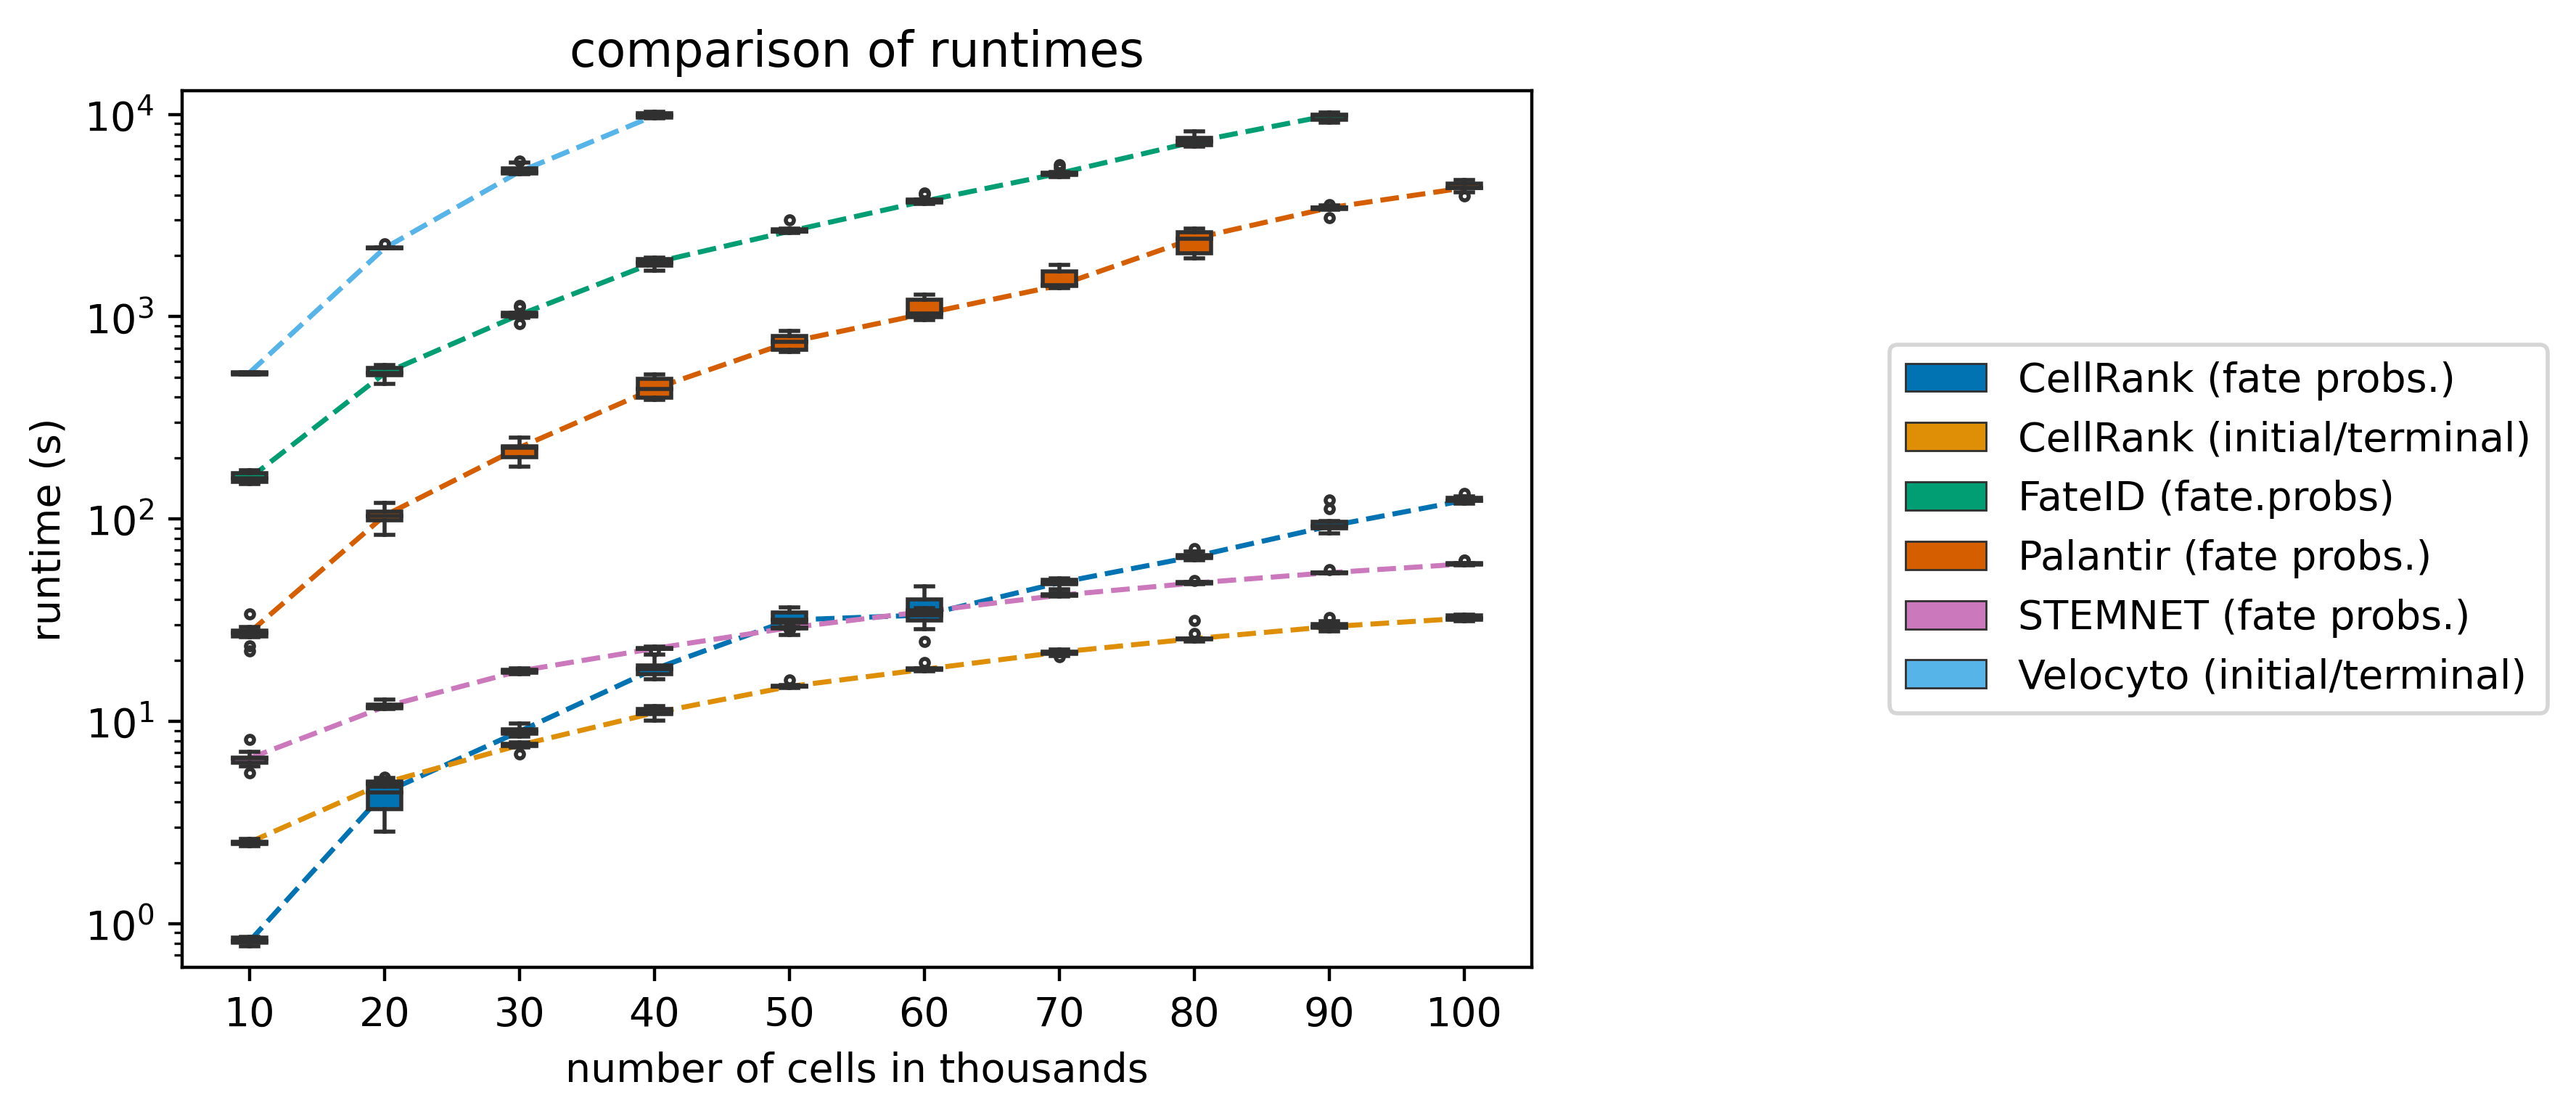

In [9]:
fig, agg = plot(res)
if save_figure:
    fig.savefig(FIG_DIR / "fig_5_benchmarking" / "compute_time_benchmark.pdf", bbox_inches='tight', transparent=True)

## Extract the data for the table creation

In [10]:
df = []
for algo, vals in agg.items():
    if algo == 'Velocyto':
        for stat in ('mean', 'std'):
            empty = np.full((10,), dtype=np.float64, fill_value=np.nan)
            empty[:len(vals[stat])] = vals[stat]
            vals[stat] = empty
    tmp = pd.DataFrame(vals)
    tmp.columns=[f'{algo} mean', f'{algo} std']
    tmp.index = [i * 10000 for i in range(1, len(tmp) + 1)]
    tmp.index.name = "size"
    df.append(tmp)
df = pd.concat(df, axis=1)

# round 
df = df.round(1)

# make the index pretty
df.index = np.array(df.index/1000, dtype='int')
df.index.name = '#cells (thousands)'

In [11]:
df

,CellRank (initial/terminal) mean,CellRank (initial/terminal) std,CellRank (fate probs.) mean,CellRank (fate probs.) std,STEMNET (fate probs.) mean,STEMNET (fate probs.) std,Palantir (fate probs.) mean,Palantir (fate probs.) std,Velocyto (initial/terminal) mean,Velocyto (initial/terminal) std,FateID (fate.probs) mean,FateID (fate.probs) std
#cells (thousands),,,,,,,,,,,,
10,2.8,0.9,1.5,2.2,6.5,0.3,27.3,3.0,525.5,5.9,160.5,8.8
20,5.0,0.1,4.2,0.8,11.9,0.4,102.5,10.4,2195.5,34.9,531.1,31.7
30,7.6,0.1,8.8,0.8,17.7,0.4,217.6,19.8,5325.9,274.0,1029.6,57.8
40,11.1,0.5,18.3,1.6,22.9,0.3,447.7,52.6,9889.8,271.9,1840.8,89.5
50,15.0,0.3,32.1,2.9,28.9,0.3,750.1,66.1,NaN,NaN,2690.5,117.5
60,18.8,2.0,35.9,6.2,35.0,0.6,1092.4,119.5,NaN,NaN,3772.8,147.0
70,21.8,0.5,48.5,1.8,42.1,0.5,1524.1,158.9,NaN,NaN,5151.4,217.9
80,26.2,1.8,65.7,2.5,48.4,0.5,2352.1,292.4,NaN,NaN,7414.3,454.8
90,29.7,1.3,96.9,11.5,54.3,0.6,3424.8,130.4,NaN,NaN,9752.7,380.9


### Save the table

In [12]:
df.to_csv(DATA_DIR / "benchmarking_results" / "suppl_tab_time_benchmark" / "statistics.csv")